In [1]:
import xlrd                                       # 读取本地excel数据
import numpy as np                                # 计算多维数组
import matplotlib.pyplot as plt                   # 画图
import warnings                                   # 提示错误或者过时的用法
import pystan                                     # 模型拟合
import arviz as az                                # 可视化贝叶斯模型结果
import pandas as pd                               # 数据分析
from scipy import stats                           # 统计工具
import seaborn as sns                             # 画图
import glob                                       # 查找目录下的文件
import os                                         # 处理目录下的文件
import pandas as pd
import pingouin as pg                             # 统计、方差分析
from openpyxl import load_workbook                # 读取xlsx
warnings.filterwarnings("ignore")                 # 忽略一些不重要的警告

E:\Program Files\anaconda\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
E:\Program Files\anaconda\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
path_reward1 = r'E:\XS\project\learning\reward1.xlsx'
path_reward2 = r'E:\XS\project\learning\reward2.xlsx'
path_reward3 = r'E:\XS\project\learning\reward3.xlsx'

In [3]:
def excel2matrix(path):
    data = xlrd.open_workbook(path)
    table = data.sheets()[0]
    nrows = table.nrows  
    ncols = table.ncols  
    datamatrix = np.zeros((nrows, ncols))
    for i in range(ncols):
        cols = table.col_values(i)
        datamatrix[:, i] = cols
    return datamatrix

reward1 = excel2matrix(path_reward1)
reward2 = excel2matrix(path_reward2)
reward3 = excel2matrix(path_reward3)

In [78]:
data = r'E:\XS\project\learning\data_nv'
address = list(np.sort(glob.glob(os.path.join(data,'reinforce*.xlsx'))))

RT_mean1= [0]*len(address)
for i in range(len(address)):
    RT = [0]*150
    datasubj = pd.read_excel(address[i])
    a = 0
    for j in range(150):
        if datasubj['RT'][j] != -999:
            RT[j] = float(datasubj['RT'][j])
        else:
            RT[j] = 0
    RT_mean1[i] = np.mean(RT)

data = r'E:\XS\project\learning\data_nan'
address = list(np.sort(glob.glob(os.path.join(data,'reinforce*.xlsx'))))

RT_mean2= [0]*len(address)
for i in range(len(address)):
    RT = [0]*150
    datasubj = pd.read_excel(address[i])
    for j in range(150):
        if datasubj['RT'][j] != -999:
            RT[j] = float(datasubj['RT'][j])
        else:
            RT[j] = 0
    RT_mean2[i] = np.mean(RT)

In [80]:
RT_mean1.extend(RT_mean2)

In [81]:
np.mean(RT_mean1)

0.43470986374702403

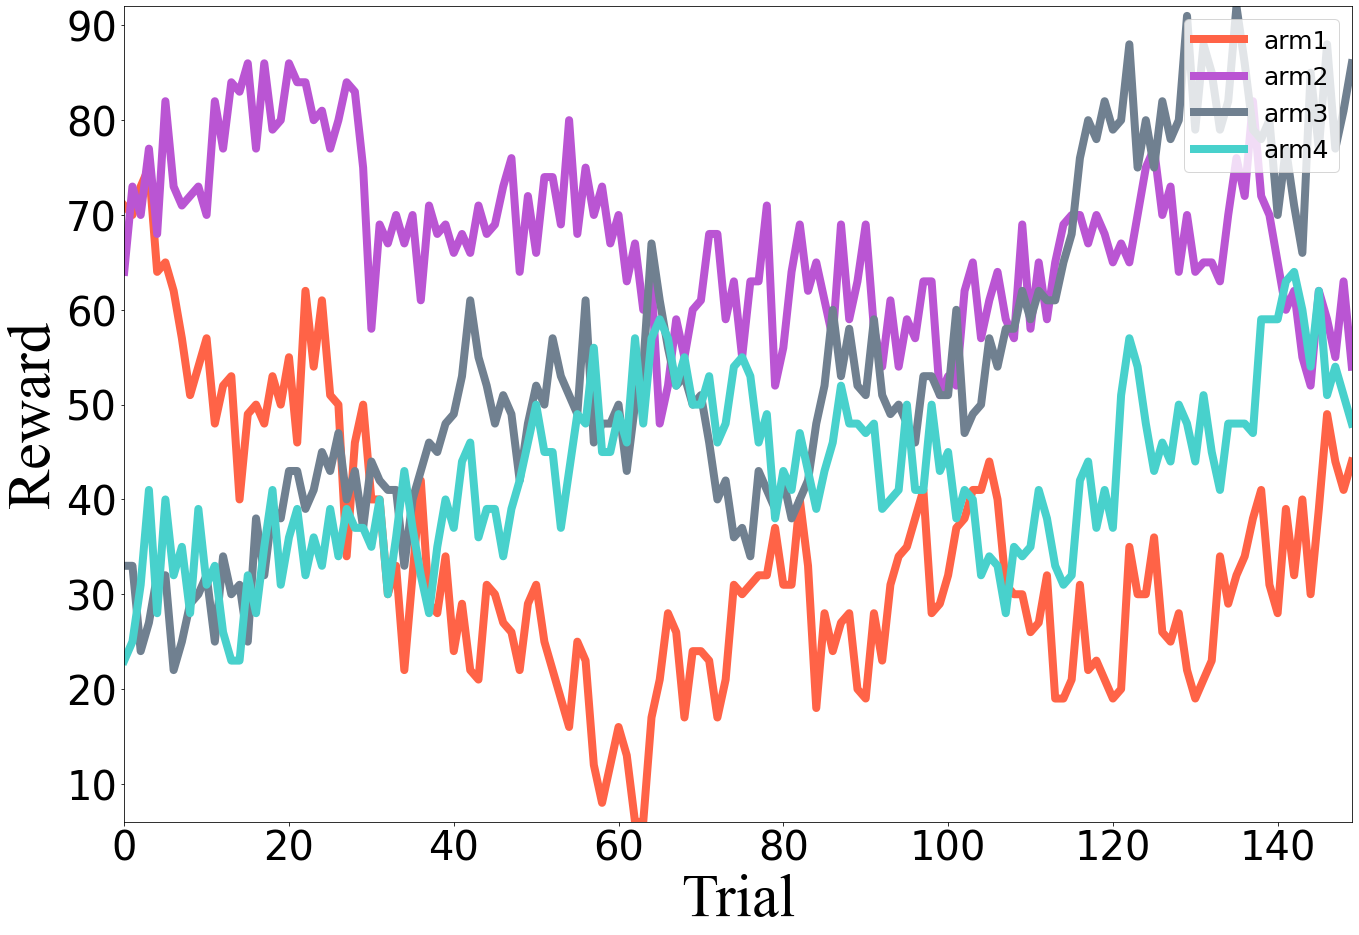

In [98]:
reward1 = pd.read_excel(r'E:\XS\project\learning\reward3.xlsx')
arm1 = [0]*150
arm2 = [0]*150
arm3 = [0]*150
arm4 = [0]*150
for i in range(150):
    arm1[i] = int(reward1['arm1'][i])
    arm2[i] = int(reward1['arm2'][i])
    arm3[i] = int(reward1['arm3'][i])
    arm4[i] = int(reward1['arm4'][i])

T = np.arange(150)
plt.figure(figsize=(22,15))
font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 60,}
plt.plot(T, arm1, label = 'arm1', color = 'tomato', linewidth =8.0)
plt.plot(T, arm2, label = 'arm2', color = 'mediumorchid', linewidth =8.0)
plt.plot(T, arm3, label = 'arm3', color = 'slategrey', linewidth =8.0)
plt.plot(T, arm4, label = 'arm4', color = 'mediumturquoise', linewidth =8.0)
plt.xlabel('Trial',font2)
plt.ylabel('Reward',font2)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)  
plt.rcParams.update({'font.size':25})
plt.autoscale(tight=True)
plt.legend(loc='upper right')
plt.savefig(r"E:\XS\project\learning\reward3.png")

In [52]:
data = r'E:\XS\project\learning\data_nv'
address = list(np.sort(glob.glob(os.path.join(data,'reinforce*.xlsx'))))

age1 = [0]*len(address)
for i in range(len(address)):
    datasubj = pd.read_excel(address[i])
    age1[i] = int(datasubj['Age'][0])

data = r'E:\XS\project\learning\data_nan'
address = list(np.sort(glob.glob(os.path.join(data,'reinforce*.xlsx'))))

age2 = [0]*len(address)
for i in range(len(address)):
    datasubj = pd.read_excel(address[i])
    age2[i] = int(datasubj['Age'][0])
    

In [53]:
age1.extend(age2)

In [62]:
np.min(age1)

18

In [15]:
data = r'E:\XS\project\learning\data'
address = list(np.sort(glob.glob(os.path.join(data,'reinforce*.xlsx'))))

In [16]:
sub_id = np.zeros(shape = (len(address), 1), dtype = int)
choose = np.zeros(shape = (150, len(address)), dtype = int)
reward = np.zeros(shape = (150, len(address)), dtype = int)
for i in range(len(address)):
    datasubj = pd.read_excel(address[i])
    sub_id[i][0] = int(datasubj['Subject'][0])
    for j in range(150):
        choose[j,i] = datasubj['Choose'][j]
        reward[j,i] = datasubj['Reward'][j]
reward.shape

(150, 82)

In [8]:
RW_model = """
data {                
    int N;                                                                    // 试次数
    int M;                                                                    // 被试数
    int C[N,M];                                                               // 选项
    int R[N,M];                                                               // 奖励
}
parameters {
    vector<lower=0, upper=1>[M] alpha;                                        // 个体被试参数学习率
    vector<lower=0, upper=10>[M] beta;                                        // 个体被试参数逆温度 
}
model {
    alpha ~ normal(0,1);                                                      // 参数的先验
    beta ~ normal(0,1);                                                       // 参数的先验
    for (s in 1:M){                                                          
        vector[N] Q1;                                                         // 第一个选项的Q 
        vector[N] Q2;                                                         // 第二个选项的Q 
        vector[N] Q3;                                                         // 第三个选项的Q 
        vector[N] Q4;                                                         // 第四个选项的Q 
        for (t in 1:N){
            vector[4] V;                                                      // 价值编码为向量
            if (t == 1){
                Q1[t] = 0;                                                       // 初始价值设置
                Q2[t] = 0;
                Q3[t] = 0;
                Q4[t] = 0;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    Q1[t] = Q1[t-1] + alpha[s]*(R[t-1,s]-Q1[t-1]);
                    Q2[t] = Q2[t-1];
                    Q3[t] = Q3[t-1];
                    Q4[t] = Q4[t-1];
                }else if (C[t-1,s] == 2){
                    Q2[t] = Q2[t-1] + alpha[s]*(R[t-1,s]-Q2[t-1]);
                    Q1[t] = Q1[t-1];
                    Q3[t] = Q3[t-1];
                    Q4[t] = Q4[t-1];
                }else if (C[t-1,s] == 3){
                    Q3[t] = Q3[t-1] + alpha[s]*(R[t-1,s]-Q3[t-1]);
                    Q1[t] = Q1[t-1];
                    Q2[t] = Q2[t-1];
                    Q4[t] = Q4[t-1];
                }else if (C[t-1,s] == 4){
                    Q4[t] = Q4[t-1] + alpha[s]*(R[t-1,s]-Q4[t-1]);
                    Q1[t] = Q1[t-1];
                    Q2[t] = Q2[t-1];
                    Q3[t] = Q3[t-1];                    
                }else{
                    Q1[t] = Q1[t-1];
                    Q2[t] = Q2[t-1];
                    Q3[t] = Q3[t-1];
                    Q4[t] = Q4[t-1];
                }
            }
            V[1] = Q1[t];
            V[2] = Q2[t];
            V[3] = Q3[t];
            V[4] = Q4[t];
            if (C[t,s] != 0){
                C[t,s] ~ categorical_logit(V*beta[s]);                            // 四项选择
            }else{

            }
        }
    }
}
generated quantities {
    real log_lik[N];                                                          // define log_like
    matrix[N,M] Q1;
    matrix[N,M] Q2;
    matrix[N,M] Q3;
    matrix[N,M] Q4;
    for (t in 1:N){
        real a;
        a = 0;
        for (s in 1:M){
            vector[4] V;
            if (t == 1){
                Q1[t,s] = 0;                                                       // 初始价值设置
                Q2[t,s] = 0;
                Q3[t,s] = 0;
                Q4[t,s] = 0;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    Q1[t,s] = Q1[t-1,s] + alpha[s]*(R[t-1,s]-Q1[t-1,s]);
                    Q2[t,s] = Q2[t-1,s];
                    Q3[t,s] = Q3[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }else if (C[t-1,s] == 2){
                    Q2[t,s] = Q2[t-1,s] + alpha[s]*(R[t-1,s]-Q2[t-1,s]);
                    Q1[t,s] = Q1[t-1,s];
                    Q3[t,s] = Q3[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }else if (C[t-1,s] == 3){
                    Q3[t,s] = Q3[t-1,s] + alpha[s]*(R[t-1,s]-Q3[t-1,s]);
                    Q2[t,s] = Q2[t-1,s];
                    Q1[t,s] = Q1[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }else if (C[t-1,s] == 4){
                    Q4[t,s] = Q4[t-1,s] + alpha[s]*(R[t-1,s]-Q4[t-1,s]);
                    Q1[t,s] = Q1[t-1,s];
                    Q2[t,s] = Q2[t-1,s];
                    Q3[t,s] = Q3[t-1,s];                  
                }else{
                    Q1[t,s] = Q1[t-1,s];
                    Q2[t,s] = Q2[t-1,s];
                    Q3[t,s] = Q3[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }
            }
            V[1] = Q1[t,s];
            V[2] = Q2[t,s];
            V[3] = Q3[t,s];
            V[4] = Q4[t,s];
            if (C[t,s] != 0){
                a = a + categorical_logit_lpmf(C[t,s] | V*beta[s]);        // sum log_like
            }else{

            }
        }
        log_lik[t] = a/M;  
    }
}
"""

In [8]:
Explor_exploi_model = """
data {                
    int N;                                                                    // 试次数
    int M;                                                                    // 被试数
    int C[N,M];                                                               // 选项
    int R[N,M];                                                               // 奖励
}
parameters {
    vector<lower=0, upper=1>[M] alpha;                                        // 个体被试参数学习率
    vector<lower=0, upper=10>[M] beta;                                        // 个体被试参数逆温度 
    vector<lower=0, upper=1>[M] delta;                                        // 个体被试参数延迟系数
    vector<lower=0, upper=1>[M] theta;                                        // 个体被试参数奖励敏感系数
    vector<lower=0>[M] fai;                                                   // 个体被试参数bond
}
model {
    alpha ~ normal(0,1);                                                      // 参数的先验
    beta ~ normal(0,1);                                                       // 参数的先验
    delta ~ normal(0,1);
    theta ~ normal(0,1);
    fai ~ normal(0,1);
    for (s in 1:M){                                                          
        vector[N] K1;                                                         // 第一个选项的K 
        vector[N] K2;                                                         // 第二个选项的K 
        vector[N] K3;                                                         // 第三个选项的K 
        vector[N] K4;                                                         // 第四个选项的K
        vector[N] T1;                                                         // 第一个选项的Q 
        vector[N] T2;                                                         // 第二个选项的Q 
        vector[N] T3;                                                         // 第三个选项的Q 
        vector[N] T4;                                                         // 第四个选项的Q
        for (t in 1:N){
            vector[4] V;                                                      // 价值编码为向量
            if (t == 1){
                K1[t] = 0;                                                       // 初始价值设置
                K2[t] = 0;
                K3[t] = 0;
                K4[t] = 0;
                T1[t] = 1;                                                       // 初始价值设置
                T2[t] = 1;
                T3[t] = 1;
                T4[t] = 1;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    K1[t] = delta[s]*K1[t-1] + pow(R[t-1,s],theta[s]);
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T1[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 2){
                    K2[t] = delta[s]*K2[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T2[t] = 0;
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 3){
                    K3[t] = delta[s]*K3[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T3[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 4){
                    K4[t] = delta[s]*K4[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    T4[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                }else{
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }
            }
            V[1] = K1[t] + T1[t];
            V[2] = K2[t] + T2[t];
            V[3] = K3[t] + T3[t];
            V[4] = K4[t] + T4[t];
            if (C[t,s] != 0){
                C[t,s] ~ categorical_logit(V*beta[s]);                            // 四项选择
            }else{

            }
        }
    }
}
generated quantities {
    real log_lik[N];                                                          // define log_like
    matrix[N,M] K1;
    matrix[N,M] K2;
    matrix[N,M] K3;
    matrix[N,M] K4;
    matrix[N,M] T1;
    matrix[N,M] T2;
    matrix[N,M] T3;
    matrix[N,M] T4;
    for (t in 1:N){
        real a;
        a = 0;
        for (s in 1:M){
            vector[4] V;
            if (t == 1){
                K1[t,s] = 0;                                                       // 初始价值设置
                K2[t,s] = 0;
                K3[t,s] = 0;
                K4[t,s] = 0;
                T1[t,s] = 1;                                                       // 初始价值设置
                T2[t,s] = 1;
                T3[t,s] = 1;
                T4[t,s] = 1;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    K1[t,s] = delta[s]*K1[t-1,s] + pow(R[t-1,s],theta[s]);
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T1[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 2){
                    K2[t,s] = delta[s]*K2[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T2[t,s] = 0;
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 3){
                    K3[t,s] = delta[s]*K3[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T3[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 4){
                    K4[t,s] = delta[s]*K4[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    T4[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                }else{
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }
            }
            V[1] = K1[t,s] + T1[t,s];
            V[2] = K2[t,s] + T2[t,s];
            V[3] = K3[t,s] + T3[t,s];
            V[4] = K4[t,s] + T4[t,s];
            if (C[t,s] != 0){
                a = a + categorical_logit_lpmf(C[t,s] | V*beta[s]);        // sum log_like
            }else{

            }
        }
        log_lik[t] = a/M;  
    }
}
"""

In [4]:
Explor_exploi_model_2 = """
data {                
    int N;                                                                    // 试次数
    int M;                                                                    // 被试数
    int C[N,M];                                                               // 选项
    int R[N,M];                                                               // 奖励
}
parameters {
    vector<lower=0, upper=1>[M] alpha;                                        // 个体被试参数学习率
    vector<lower=0, upper=10>[M] beta;                                        // 个体被试参数逆温度 
    vector<lower=0, upper=1>[M] delta;                                        // 个体被试参数延迟系数
    vector<lower=0, upper=1>[M] theta;                                        // 个体被试参数奖励敏感系数
    vector<lower=-5, upper=5>[M] fai;                                                   // 个体被试参数bond
    vector<lower=0, upper=1>[M] gamma;
}
model {
    alpha ~ normal(0,1);                                                      // 参数的先验
    beta ~ normal(0,1);                                                       // 参数的先验
    delta ~ normal(0,1);
    theta ~ normal(0,1);
    fai ~ normal(0,1);
    gamma ~ normal(0,1);
    for (s in 1:M){                                                          
        vector[N] K1;                                                         // 第一个选项的K 
        vector[N] K2;                                                         // 第二个选项的K 
        vector[N] K3;                                                         // 第三个选项的K 
        vector[N] K4;                                                         // 第四个选项的K
        vector[N] T1;                                                         // 第一个选项的Q 
        vector[N] T2;                                                         // 第二个选项的Q 
        vector[N] T3;                                                         // 第三个选项的Q 
        vector[N] T4;                                                         // 第四个选项的Q
        for (t in 1:N){
            vector[4] V;                                                      // 价值编码为向量
            if (t == 1){
                K1[t] = 0;                                                       // 初始价值设置
                K2[t] = 0;
                K3[t] = 0;
                K4[t] = 0;
                T1[t] = 1;                                                       // 初始价值设置
                T2[t] = 1;
                T3[t] = 1;
                T4[t] = 1;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    K1[t] = delta[s]*K1[t-1] + pow(R[t-1,s],theta[s]);
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T1[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 2){
                    K2[t] = delta[s]*K2[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T2[t] = 0;
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 3){
                    K3[t] = delta[s]*K3[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T3[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 4){
                    K4[t] = delta[s]*K4[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    T4[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                }else{
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }
            }
            V[1] = gamma[s]*K1[t] + (1 - gamma[s])*T1[t];
            V[2] = gamma[s]*K2[t] + (1 - gamma[s])*T2[t];
            V[3] = gamma[s]*K3[t] + (1 - gamma[s])*T3[t];
            V[4] = gamma[s]*K4[t] + (1 - gamma[s])*T4[t];
            if (C[t,s] != 0){
                C[t,s] ~ categorical_logit(V*beta[s]);                            // 四项选择
            }else{

            }
        }
    }
}
generated quantities {
    real log_lik[N];                                                          // define log_like
    matrix[N,M] K1;
    matrix[N,M] K2;
    matrix[N,M] K3;
    matrix[N,M] K4;
    matrix[N,M] T1;
    matrix[N,M] T2;
    matrix[N,M] T3;
    matrix[N,M] T4;
    for (t in 1:N){
        real a;
        a = 0;
        for (s in 1:M){
            vector[4] V;
            if (t == 1){
                K1[t,s] = 0;                                                       // 初始价值设置
                K2[t,s] = 0;
                K3[t,s] = 0;
                K4[t,s] = 0;
                T1[t,s] = 1;                                                       // 初始价值设置
                T2[t,s] = 1;
                T3[t,s] = 1;
                T4[t,s] = 1;
            }else{
                if (C[t-1,s] == 1){                                                // 价值更新
                    K1[t,s] = delta[s]*K1[t-1,s] + pow(R[t-1,s],theta[s]);
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T1[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 2){
                    K2[t,s] = delta[s]*K2[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T2[t,s] = 0;
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 3){
                    K3[t,s] = delta[s]*K3[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T3[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 4){
                    K4[t,s] = delta[s]*K4[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    T4[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                }else{
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }
            }
            V[1] = gamma[s]*K1[t,s] + (1 - gamma[s])*T1[t,s];
            V[2] = gamma[s]*K2[t,s] + (1 - gamma[s])*T2[t,s];
            V[3] = gamma[s]*K3[t,s] + (1 - gamma[s])*T3[t,s];
            V[4] = gamma[s]*K4[t,s] + (1 - gamma[s])*T4[t,s];
            if (C[t,s] != 0){
                a = a + categorical_logit_lpmf(C[t,s] | V*beta[s]);        // sum log_like
            }else{

            }
        }
        log_lik[t] = a/M;  
    }
}
"""

In [ ]:
Hierarchy_Explor_exploi_model_2 = """
data {                
    int N;                                                                    // 试次数
    int M;                                                                    // 被试数
    int C[N,M];                                                               // 选项
    int R[N,M];                                                               // 奖励
}
parameters {
    real alpha;                                        // 个体被试参数学习率
    real beta;                                        // 个体被试参数逆温度 
    real delta;                                        // 个体被试参数延迟系数
    real theta;                                        // 个体被试参数奖励敏感系数
    real fai;                                                   // 个体被试参数bond
    real gamma;
    real<lower=0> alpha_sd
    real<lower=0> beta_sd
    real<lower=0> delta_sd
    real<lower=0> theta_sd
    real<lower=0> fai_sd
    real<lower=0> gamma_sd
    vector[M] ALPHA;
    vector[M] BETA;
    vector[M] DELTA;
    vector[M] THETA;
    vector[M] FAI;
    vector[M] GAMMA;
}
transformed parameters{
    vector<lower=0, upper=1>[M] Alpha;                                       // group_level
    vector<lower=0, upper=10>[M] Beta;                                        // group_level
    vector<lower=0, upper=1>[M] Delta;                                       // group_level
    vector<lower=0, upper=1>[M] Theta;
    vector<lower=-5, upper=5>[M] Fai;
    vector<lower=0, upper=1>[M] Gamma;
    for (s in 1:M){
        Alpha[s] = ((Phi_approx(alpha_m_raw + alpha_sd_raw*ALPHA[s]))*4)-2;   // group_level
        Beta[s] = ((Phi_approx(beta_m_raw + beta_sd_raw*BETA[s]))*4)-2;       // group_level
        Lambda[s] = (Phi_approx(lambda_m_raw + lambda_sd_raw*LAMBDA[s]))*5;   // group_level
    }
}
model {
    alpha ~ normal(0,1);                                                      // 参数的先验
    beta ~ normal(0,1);                                                       // 参数的先验
    delta ~ normal(0,1);
    theta ~ normal(0,1);
    fai ~ normal(0,1);
    gamma ~ normal(0,1);
    for (s in 1:M){                                                          
        vector[N] K1;                                                         // 第一个选项的K 
        vector[N] K2;                                                         // 第二个选项的K 
        vector[N] K3;                                                         // 第三个选项的K 
        vector[N] K4;                                                         // 第四个选项的K
        vector[N] T1;                                                         // 第一个选项的Q 
        vector[N] T2;                                                         // 第二个选项的Q 
        vector[N] T3;                                                         // 第三个选项的Q 
        vector[N] T4;                                                         // 第四个选项的Q
        for (t in 1:N){
            vector[4] V;                                                      // 价值编码为向量
            if (t == 1){
                K1[t] = 0;                                                       // 初始价值设置
                K2[t] = 0;
                K3[t] = 0;
                K4[t] = 0;
                T1[t] = 1;                                                       // 初始价值设置
                T2[t] = 1;
                T3[t] = 1;
                T4[t] = 1;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    K1[t] = delta[s]*K1[t-1] + pow(R[t-1,s],theta[s]);
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T1[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 2){
                    K2[t] = delta[s]*K2[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T2[t] = 0;
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 3){
                    K3[t] = delta[s]*K3[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T3[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }else if (C[t-1,s] == 4){
                    K4[t] = delta[s]*K4[t-1] + pow(R[t-1,s],theta[s]);
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    T4[t] = 0;
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                }else{
                    K1[t] = delta[s]*K1[t-1];
                    K2[t] = delta[s]*K2[t-1];
                    K3[t] = delta[s]*K3[t-1];
                    K4[t] = delta[s]*K4[t-1];
                    T1[t] = T1[t-1] + alpha[s]*(fai[s] - T1[t-1]);
                    T2[t] = T2[t-1] + alpha[s]*(fai[s] - T2[t-1]);
                    T3[t] = T3[t-1] + alpha[s]*(fai[s] - T3[t-1]);
                    T4[t] = T4[t-1] + alpha[s]*(fai[s] - T4[t-1]);
                }
            }
            V[1] = gamma[s]*K1[t] + (1 - gamma[s])*T1[t];
            V[2] = gamma[s]*K2[t] + (1 - gamma[s])*T2[t];
            V[3] = gamma[s]*K3[t] + (1 - gamma[s])*T3[t];
            V[4] = gamma[s]*K4[t] + (1 - gamma[s])*T4[t];
            if (C[t,s] != 0){
                C[t,s] ~ categorical_logit(V*beta[s]);                            // 四项选择
            }else{

            }
        }
    }
}
generated quantities {
    real log_lik[N];                                                          // define log_like
    matrix[N,M] K1;
    matrix[N,M] K2;
    matrix[N,M] K3;
    matrix[N,M] K4;
    matrix[N,M] T1;
    matrix[N,M] T2;
    matrix[N,M] T3;
    matrix[N,M] T4;
    for (t in 1:N){
        real a;
        a = 0;
        for (s in 1:M){
            vector[4] V;
            if (t == 1){
                K1[t,s] = 0;                                                       // 初始价值设置
                K2[t,s] = 0;
                K3[t,s] = 0;
                K4[t,s] = 0;
                T1[t,s] = 1;                                                       // 初始价值设置
                T2[t,s] = 1;
                T3[t,s] = 1;
                T4[t,s] = 1;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    K1[t,s] = delta[s]*K1[t-1,s] + pow(R[t-1,s],theta[s]);
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T1[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 2){
                    K2[t,s] = delta[s]*K2[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T2[t,s] = 0;
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 3){
                    K3[t,s] = delta[s]*K3[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T3[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }else if (C[t-1,s] == 4){
                    K4[t,s] = delta[s]*K4[t-1,s] + pow(R[t-1,s],theta[s]);
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    T4[t,s] = 0;
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                }else{
                    K1[t,s] = delta[s]*K1[t-1,s];
                    K2[t,s] = delta[s]*K2[t-1,s];
                    K3[t,s] = delta[s]*K3[t-1,s];
                    K4[t,s] = delta[s]*K4[t-1,s];
                    T1[t,s] = T1[t-1,s] + alpha[s]*(fai[s] - T1[t-1,s]);
                    T2[t,s] = T2[t-1,s] + alpha[s]*(fai[s] - T2[t-1,s]);
                    T3[t,s] = T3[t-1,s] + alpha[s]*(fai[s] - T3[t-1,s]);
                    T4[t,s] = T4[t-1,s] + alpha[s]*(fai[s] - T4[t-1,s]);
                }
            }
            V[1] = gamma[s]*K1[t,s] + (1 - gamma[s])*T1[t,s];
            V[2] = gamma[s]*K2[t,s] + (1 - gamma[s])*T2[t,s];
            V[3] = gamma[s]*K3[t,s] + (1 - gamma[s])*T3[t,s];
            V[4] = gamma[s]*K4[t,s] + (1 - gamma[s])*T4[t,s];
            if (C[t,s] != 0){
                a = a + categorical_logit_lpmf(C[t,s] | V*beta[s]);        // sum log_like
            }else{

            }
        }
        log_lik[t] = a/M;  
    }
}
"""

In [8]:
PVL_model = """
data {                
    int N;                                                                    // 试次数
    int M;                                                                    // 被试数
    int C[N,M];                                                               // 选项
    int R[N,M];                                                               // 奖励
}
parameters {
    vector<lower=0, upper=1>[M] alpha;                                        // 个体被试参数学习率
    vector<lower=0, upper=10>[M] beta;                                        // 个体被试参数逆温度 
    vector<lower=0, upper=1>[M] theta;                                        // 个体被试参数逆温度
}
model {
    alpha ~ normal(0,1);                                                      // 参数的先验
    beta ~ normal(0,1);                                                       // 参数的先验
    theta ~ normal(0,1);
    for (s in 1:M){                                                          
        vector[N] Q1;                                                         // 第一个选项的K 
        vector[N] Q2;                                                         // 第二个选项的K 
        vector[N] Q3;                                                         // 第三个选项的K 
        vector[N] Q4;                                                         // 第四个选项的K
        for (t in 1:N){
            vector[4] V;                                                      // 价值编码为向量
            if (t == 1){
                Q1[t] = 0;                                                       // 初始价值设置
                Q2[t] = 0;
                Q3[t] = 0;
                Q4[t] = 0;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    Q1[t] = Q1[t-1] + alpha[s]*(pow(R[t-1,s],theta[s])-Q1[t-1]);
                    Q2[t] = Q2[t-1];
                    Q3[t] = Q3[t-1];
                    Q4[t] = Q4[t-1];
                }else if (C[t-1,s] == 2){
                    Q2[t] = Q2[t-1] + alpha[s]*(pow(R[t-1,s],theta[s])-Q2[t-1]);
                    Q1[t] = Q1[t-1];
                    Q3[t] = Q3[t-1];
                    Q4[t] = Q4[t-1];
                }else if (C[t-1,s] == 3){
                    Q3[t] = Q3[t-1] + alpha[s]*(pow(R[t-1,s],theta[s])-Q3[t-1]);
                    Q1[t] = Q1[t-1];
                    Q2[t] = Q2[t-1];
                    Q4[t] = Q4[t-1];
                }else if (C[t-1,s] == 4){
                    Q4[t] = Q4[t-1] + alpha[s]*(pow(R[t-1,s],theta[s])-Q4[t-1]);
                    Q1[t] = Q1[t-1];
                    Q2[t] = Q2[t-1];
                    Q3[t] = Q3[t-1];                    
                }else{
                    Q1[t] = Q1[t-1];
                    Q2[t] = Q2[t-1];
                    Q3[t] = Q3[t-1];
                    Q4[t] = Q4[t-1];
                }
            }
            V[1] = Q1[t];
            V[2] = Q2[t];
            V[3] = Q3[t];
            V[4] = Q4[t];
            if (C[t,s] != 0){
                C[t,s] ~ categorical_logit(V*beta[s]);                            // 四项选择
            }else{

            }
        }
    }
}
generated quantities {
    real log_lik[N];                                                          // define log_like
    matrix[N,M] Q1;
    matrix[N,M] Q2;
    matrix[N,M] Q3;
    matrix[N,M] Q4;
    for (t in 1:N){
        real a;
        a = 0;
        for (s in 1:M){
            vector[4] V;
            if (t == 1){
                Q1[t,s] = 0;                                                       // 初始价值设置
                Q2[t,s] = 0;
                Q3[t,s] = 0;
                Q4[t,s] = 0;
            }else{
                if (C[t-1,s] == 1){                                             // 价值更新
                    Q1[t,s] = Q1[t-1,s] + alpha[s]*(pow(R[t-1,s],theta[s])-Q1[t-1,s]);
                    Q2[t,s] = Q2[t-1,s];
                    Q3[t,s] = Q3[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }else if (C[t-1,s] == 2){
                    Q2[t,s] = Q2[t-1,s] + alpha[s]*(pow(R[t-1,s],theta[s])-Q2[t-1,s]);
                    Q1[t,s] = Q1[t-1,s];
                    Q3[t,s] = Q3[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }else if (C[t-1,s] == 3){
                    Q3[t,s] = Q3[t-1,s] + alpha[s]*(pow(R[t-1,s],theta[s])-Q3[t-1,s]);
                    Q2[t,s] = Q2[t-1,s];
                    Q1[t,s] = Q1[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }else if (C[t-1,s] == 4){
                    Q4[t,s] = Q4[t-1,s] + alpha[s]*(pow(R[t-1,s],theta[s])-Q4[t-1,s]);
                    Q1[t,s] = Q1[t-1,s];
                    Q2[t,s] = Q2[t-1,s];
                    Q3[t,s] = Q3[t-1,s];                  
                }else{
                    Q1[t,s] = Q1[t-1,s];
                    Q2[t,s] = Q2[t-1,s];
                    Q3[t,s] = Q3[t-1,s];
                    Q4[t,s] = Q4[t-1,s];
                }
            }
            V[1] = Q1[t,s];
            V[2] = Q2[t,s];
            V[3] = Q3[t,s];
            V[4] = Q4[t,s];
            if (C[t,s] != 0){
                a = a + categorical_logit_lpmf(C[t,s] | V*beta[s]);        // sum log_like
            }else{

            }
        }
        log_lik[t] = a/M;  
    }
}
"""

In [9]:
RW_model = pystan.model.StanModel(model_code = RW_model,
                                 model_name='RW_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL RW_model_72e35452a032567e902f693422a6fd90 NOW.


In [9]:
Explor_exploi_model = pystan.model.StanModel(model_code = Explor_exploi_model,
                                 model_name='Explor_exploi_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Explor_exploi_model_8962e414e6bbd05300203ee06bffdf43 NOW.


In [5]:
Explor_exploi_model_2 = pystan.model.StanModel(model_code = Explor_exploi_model_2,
                                 model_name='Explor_exploi_model_2')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Explor_exploi_model_2_776ddf29ae0f3308e3b01ca6877a7f9f NOW.


In [9]:
PVL_model = pystan.model.StanModel(model_code = PVL_model,
                                 model_name='PVL_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL PVL_model_d90b5051bf9adabb8bea8de8865388a9 NOW.


In [10]:
RW_fit = RW_model.sampling(data={'N': 150,
                               'M': 82,
                               'C': choose, 
                               'R': reward},
                          iter=2000, chains=4,
                          warmup=1000,n_jobs=-1,
                          seed=2001110667)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
KT_fit = Explor_exploi_model.sampling(data={'N': 150,
                               'M': 82,
                               'C': choose, 
                               'R': reward},
                          iter=2000, chains=4,
                          warmup=1000,n_jobs=-1,
                          seed=2001110667)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
KT2_fit = Explor_exploi_model_2.sampling(data={'N': 150,
                               'M': 82,
                               'C': choose, 
                               'R': reward},
                          iter=2000, chains=4,
                          warmup=1000,n_jobs=-1,
                          seed=2001110667)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
PVL_fit = PVL_model.sampling(data={'N': 150,
                               'M': 82,
                               'C': choose, 
                               'R': reward},
                          iter=2000, chains=4,
                          warmup=1000,n_jobs=-1,
                          seed=2001110667)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
KT2_fit


For the full summary use 'print(fit)'

Inference for Stan model: Explor_exploi_model_2_7907534781a3036619ac9c10e6993d06.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]    0.14  2.7e-3    0.1   0.03   0.07   0.11   0.17   0.41   1410    1.0
alpha[2]    0.29  3.0e-3   0.15   0.08   0.18   0.26   0.37   0.66   2488    1.0
alpha[3]    0.34  2.6e-3   0.14   0.13   0.23   0.31   0.42   0.66   2736    1.0
alpha[4]    0.33  3.3e-3    0.2   0.04   0.18   0.31   0.47   0.77   3609    1.0
alpha[5]    0.45  4.0e-3   0.26   0.03   0.23   0.43   0.65   0.94   4259    1.0
alpha[6]     0.5  3.1e-3   0.17   0.24   0.38   0.48    0.6   0.89   2877    1.0
alpha[7]    0.21  4.2e-3   0.19   0.02   0.09   0.15   0.27   0.77   1985    1.0
alpha[8]    0.18  4.0e-3   0.12   0.06   0.11   0.14    0.2   0.57    929   1.01
alpha[9]    0.19  5.0e-3    0.2

In [12]:
KT2_llf= az.from_pystan(KT2_fit, log_likelihood="log_lik",observed_data='C')

In [13]:
az.to_netcdf(KT2_llf,'E:\XS\project\learning\KT2 model\KT2_result')

'E:\\XS\\project\\learning\\KT2 model\\KT2_result'

In [22]:
savedir = r"E:\XS\project\learning\KT2 parameter recovery"
np.savetxt(os.path.join(savedir,'fai_simulation.txt'),Fai)

In [22]:
dir = r"E:\XS\project\learning\KT2 model\KT2_result"
dir

'E:\\XS\\project\\learning\\KT2 model\\KT2_result'

In [21]:
KT2 = az.from_netcdf('E:\XS\project\learning\KT2 model\KT2_result')

In [22]:
KT = az.from_netcdf('E:\XS\project\learning\KT model\KT_result')

In [23]:
PVL = az.from_netcdf('E:\XS\project\learning\PVL model\PVL_result')

In [24]:
RW = az.from_netcdf('E:\XS\project\learning\RW model\RW_result')

In [25]:
compare_dic = {'model_1':RW,'model_2':KT,'model_3':KT2,'model_4':PVL}

In [26]:
az.compare(compare_dic,ic="loo", method="stacking", scale="log")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_3,0,-118.108433,0.051952,0.000000,1.000000e+00,2.686579,0.000000,False,log
model_2,1,-123.210545,0.052441,5.102112,3.410605e-13,2.775894,0.307522,False,log
model_1,2,-130.960696,0.049234,12.852263,3.452794e-14,4.017619,2.512361,True,log
model_4,3,-132.010029,0.058524,13.901596,0.000000e+00,4.049130,2.545379,True,log


In [28]:
reward.shape

(150, 82)

仿真

In [6]:
alpha = 0.35
beta = 1.60
theta = 0.70
delta = 0.55
fai = 0
gamma = 0.15
alpha_sd = 0.2
beta_sd = 0.40
theta_sd = 0.10
delta_sd = 0.15
fai_sd = 0.30
gamma_sd = 0.05
choose = np.zeros(shape = (150,50), dtype = int)
reward = np.zeros(shape = (150,50), dtype = int)
np.random.seed(20230321)

path_reward1 = r'E:\XS\project\learning\reward1.xlsx'
path_reward2 = r'E:\XS\project\learning\reward2.xlsx'
path_reward3 = r'E:\XS\project\learning\reward3.xlsx'
def excel2matrix(path):
    data = xlrd.open_workbook(path)
    table = data.sheets()[0]
    nrows = table.nrows  
    ncols = table.ncols  
    datamatrix = np.zeros((nrows, ncols))
    for i in range(ncols):
        cols = table.col_values(i)
        datamatrix[:, i] = cols
    return datamatrix

reward1 = excel2matrix(path_reward1)
reward2 = excel2matrix(path_reward2)
reward3 = excel2matrix(path_reward3)

Alpha = np.random.normal(loc = alpha, scale = alpha_sd, size = 50)
Beta = np.random.normal(loc = beta, scale = beta_sd, size = 50)
Theta = np.random.normal(loc = theta, scale = theta_sd, size = 50)
Gamma = np.random.normal(loc = gamma, scale = gamma_sd, size = 50)
Delta = np.random.normal(loc = delta, scale = delta_sd, size = 50)
Fai = np.random.normal(loc = fai, scale = fai_sd, size = 50)

K1 = np.zeros(shape = (150,50))
K2 = np.zeros(shape = (150,50))
K3 = np.zeros(shape = (150,50))
K4 = np.zeros(shape = (150,50))
T1 = np.zeros(shape = (150,50))
T2 = np.zeros(shape = (150,50))
T3 = np.zeros(shape = (150,50))
T4 = np.zeros(shape = (150,50))

for i in range(50):
    
    if np.mod(i+1,3) == 0:
        Reward = reward1
    elif np.mod(i+1,3) == 1:
        Reward = reward2
    else:
        Reward = reward3
        
    for j in range(150):
        if j == 0:
            K1[j,i] = 0
            K2[j,i] = 0
            K3[j,i] = 0
            K4[j,i] = 0
            T1[j,i] = 1
            T2[j,i] = 1
            T3[j,i] = 1
            T4[j,i] = 1
        else:
            if choose[j-1,i] == 1:
                K1[j,i] = Delta[i] * K1[j-1,i] + np.power(reward[j-1,i],Theta[i])
                K2[j,i] = Delta[i] * K2[j-1,i]
                K3[j,i] = Delta[i] * K3[j-1,i]
                K4[j,i] = Delta[i] * K4[j-1,i]
                T1[j,i] = 0
                T2[j,i] = T2[j-1,i] + Alpha[i] * (Fai[i] - T2[j-1,i])
                T3[j,i] = T3[j-1,i] + Alpha[i] * (Fai[i] - T3[j-1,i])
                T4[j,i] = T4[j-1,i] + Alpha[i] * (Fai[i] - T4[j-1,i])
            elif choose[j-1,i] == 2:
                K2[j,i] = Delta[i] * K2[j-1,i] + np.power(reward[j-1,i],Theta[i])
                K1[j,i] = Delta[i] * K1[j-1,i]
                K3[j,i] = Delta[i] * K3[j-1,i]
                K4[j,i] = Delta[i] * K4[j-1,i]
                T2[j,i] = 0
                T1[j,i] = T1[j-1,i] + Alpha[i] * (Fai[i] - T1[j-1,i])
                T3[j,i] = T3[j-1,i] + Alpha[i] * (Fai[i] - T3[j-1,i])
                T4[j,i] = T4[j-1,i] + Alpha[i] * (Fai[i] - T4[j-1,i])
            elif choose[j-1,i] == 3:
                K3[j,i] = Delta[i] * K3[j-1,i] + np.power(reward[j-1,i],Theta[i])
                K1[j,i] = Delta[i] * K1[j-1,i]
                K2[j,i] = Delta[i] * K2[j-1,i]
                K4[j,i] = Delta[i] * K4[j-1,i]
                T3[j,i] = 0
                T1[j,i] = T1[j-1,i] + Alpha[i] * (Fai[i] - T1[j-1,i])
                T2[j,i] = T2[j-1,i] + Alpha[i] * (Fai[i] - T2[j-1,i])
                T4[j,i] = T4[j-1,i] + Alpha[i] * (Fai[i] - T4[j-1,i])
            else:
                K4[j,i] = Delta[i] * K4[j-1,i] + np.power(reward[j-1,i],Theta[i])
                K1[j,i] = Delta[i] * K1[j-1,i]
                K2[j,i] = Delta[i] * K2[j-1,i]
                K3[j,i] = Delta[i] * K3[j-1,i]
                T4[j,i] = 0
                T1[j,i] = T1[j-1,i] + Alpha[i] * (Fai[i] - T1[j-1,i])
                T2[j,i] = T2[j-1,i] + Alpha[i] * (Fai[i] - T2[j-1,i])
                T3[j,i] = T3[j-1,i] + Alpha[i] * (Fai[i] - T3[j-1,i])
        V1 = Gamma[i]*K1[j,i] + (1 - Gamma[i])*T1[j,i]
        V2 = Gamma[i]*K2[j,i] + (1 - Gamma[i])*T2[j,i]
        V3 = Gamma[i]*K3[j,i] + (1 - Gamma[i])*T3[j,i]
        V4 = Gamma[i]*K4[j,i] + (1 - Gamma[i])*T4[j,i]
        p1 = np.exp(Beta[i]*V1)/(np.exp(Beta[i]*V1) + np.exp(Beta[i]*V2) + np.exp(Beta[i]*V3) + np.exp(Beta[i]*V4))
        p2 = np.exp(Beta[i]*V2)/(np.exp(Beta[i]*V1) + np.exp(Beta[i]*V2) + np.exp(Beta[i]*V3) + np.exp(Beta[i]*V4))
        p3 = np.exp(Beta[i]*V3)/(np.exp(Beta[i]*V1) + np.exp(Beta[i]*V2) + np.exp(Beta[i]*V3) + np.exp(Beta[i]*V4))
        p4 = np.exp(Beta[i]*V4)/(np.exp(Beta[i]*V1) + np.exp(Beta[i]*V2) + np.exp(Beta[i]*V3) + np.exp(Beta[i]*V4))
        choose[j,i] = int(np.random.choice([1,2,3,4],1,p=[p1,p2,p3,p4]))
        reward[j,i] = int(Reward[j,choose[j,i]-1])
    

In [7]:
KT2_fit = Explor_exploi_model_2.sampling(data={'N': 150,
                               'M': 50,
                               'C': choose, 
                               'R': reward},
                          iter=2000, chains=4,
                          warmup=1000,n_jobs=-1,
                          seed=2001110667)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [43]:
stats.pearsonr(np.mean(KT2_fit['theta'],axis = 0),np.mean(KT2_fit['alpha'],axis = 0))

(0.44877156089625825, 0.0010800945264925754)

In [31]:
np.mean(KT2_fit['theta'],axis = 0)

array([0.70133205, 0.45836645, 0.39984894, 0.6671815 , 0.69969973])

In [30]:
Theta

array([0.70482775, 0.57655185, 0.73026417, 0.60868479, 0.64228908,
       0.81895129, 0.71794432, 0.49667087, 0.8526804 , 0.82117178,
       0.75042405, 0.52704406, 0.76807225, 0.76332882, 0.72410594,
       0.8345475 , 0.88681524, 0.65678731, 0.62171417, 0.79624328,
       0.52237412, 0.6240079 , 0.73580439, 0.5639266 , 0.75507551,
       0.66394853, 0.79929913, 0.84897119, 0.74388039, 0.67658727,
       0.81440519, 0.54264049, 0.52038192, 0.65969417, 0.6061381 ,
       0.85042654, 0.94404538, 0.67154065, 0.514778  , 0.59856912,
       0.67977729, 0.8019219 , 0.64210152, 0.76725644, 0.6844577 ,
       0.84771474, 0.74952992, 0.70345242, 0.7480668 , 0.74277862])

In [37]:
KT2_fit


For the full summary use 'print(fit)'

Inference for Stan model: Explor_exploi_model_2_7907534781a3036619ac9c10e6993d06.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]    0.46  3.4e-3   0.28   0.02   0.22   0.45   0.69   0.96   6794    1.0
alpha[2]    0.48  3.5e-3   0.27   0.03   0.24   0.47    0.7   0.96   6117    1.0
alpha[3]    0.52  3.8e-3   0.27   0.03   0.31   0.52   0.74   0.97   5132    1.0
alpha[4]    0.32  3.6e-3   0.19   0.05   0.18   0.28   0.41   0.82   2830    1.0
alpha[5]    0.45  3.7e-3   0.29   0.02   0.19   0.41   0.69   0.97   5893    1.0
alpha[6]    0.46  4.2e-3   0.29   0.02   0.21   0.44    0.7   0.97   4707    1.0
alpha[7]    0.46  3.8e-3   0.27   0.03   0.23   0.45   0.68   0.96   5163    1.0
alpha[8]    0.29  1.8e-3   0.12    0.1    0.2   0.27   0.36   0.54   4062    1.0
alpha[9]    0.46  3.9e-3   0.29

In [53]:
np.mean(KT2_fit['fai'],axis = 0)

array([0.77830345, 0.81630151, 0.85424851, 1.32289197, 0.93300055,
       0.78784519, 1.10335382, 1.56666016, 0.78337571, 0.79677086,
       0.76819499, 1.545533  , 0.88950538, 0.82205715, 0.80816295,
       0.82700942, 0.79255003, 0.76987721, 0.9985456 , 0.78631433,
       1.57311246, 0.75446231, 0.83362529, 1.11019798, 0.78505811,
       0.79436339, 0.78173781, 0.84087184, 0.77244485, 1.63013538,
       0.81649653, 1.03775601, 0.77571955, 0.91049431, 1.1057103 ,
       0.85807978, 0.80660677, 1.97575608, 1.35583232, 0.85508615,
       0.76755504, 0.77472164, 0.74102544, 0.80513991, 0.78114223,
       0.84257953, 0.92659504, 1.72194567, 0.78245348, 0.77442518])

In [54]:
np.mean(KT2_fit['alpha'],axis = 0)

array([0.45902525, 0.46651316, 0.52707547, 0.28300715, 0.51424088,
       0.46021653, 0.49133392, 0.333602  , 0.46208348, 0.4609702 ,
       0.4660595 , 0.37723031, 0.45619132, 0.43389027, 0.45953046,
       0.44406028, 0.45857011, 0.45161873, 0.44905788, 0.45857259,
       0.46063257, 0.43557857, 0.45547072, 0.43476538, 0.45637267,
       0.44766702, 0.46394776, 0.46080853, 0.45929713, 0.23708264,
       0.44846611, 0.47873451, 0.44685505, 0.42308982, 0.42260789,
       0.44689951, 0.45666195, 0.36257184, 0.31061588, 0.45130383,
       0.46584675, 0.45892009, 0.42287966, 0.45287956, 0.45881487,
       0.46706771, 0.47277564, 0.21321296, 0.45581502, 0.45822639])

In [55]:
stats.pearsonr(np.mean(KT2_fit['fai'],axis = 0),np.mean(KT2_fit['alpha'],axis = 0))

(-0.7382498941926661, 9.459101576033364e-10)

In [57]:
stats.pearsonr(np.mean(KT2_fit['fai'],axis = 0),Fai)

(-0.028247539905942545, 0.8456066371101006)

In [ ]:
alpha = 0.35
beta = 0.3
alpha_sd = 0.2
beta_sd = 0.1
choose = np.zeros(shape = (150,50), dtype = int)
reward = np.zeros(shape = (150,50), dtype = int)
np.random.seed(20230321)

path_reward1 = r'E:\XS\project\learning\reward1.xlsx'
path_reward2 = r'E:\XS\project\learning\reward2.xlsx'
path_reward3 = r'E:\XS\project\learning\reward3.xlsx'
def excel2matrix(path):
    data = xlrd.open_workbook(path)
    table = data.sheets()[0]
    nrows = table.nrows  
    ncols = table.ncols  
    datamatrix = np.zeros((nrows, ncols))
    for i in range(ncols):
        cols = table.col_values(i)
        datamatrix[:, i] = cols
    return datamatrix

reward1 = excel2matrix(path_reward1)
reward2 = excel2matrix(path_reward2)
reward3 = excel2matrix(path_reward3)

Alpha = np.random.normal(loc = alpha, scale = alpha_sd, size = 50)
Beta = np.random.normal(loc = beta, scale = beta_sd, size = 50)